# Multimodal Large Language Models with LangChain, Gemini & BLIP-2

This Colab notebook demonstrates the power of **multimodal language models** by integrating several state-of-the-art tools for visual and textual reasoning:

* **Image Captioning** with ViT-GPT2
* **Visual Question Answering (VQA)** with BLIP and BLIP-2
* **Agent-Based Multimodal Reasoning** using **LangChain** and **Gemini Pro**
* **Image input from URLs** — no file uploads required
* **Zero-shot classification** and **image-text similarity** with CLIP
* **Object grounding** with OWL-ViT
* **OCR extraction** using Tesseract
* LangChain tools enable reasoning pipelines where language models **call vision models** as tools.

In [1]:
!pip install transformers torchvision datasets diffusers accelerate timm sentencepiece pytesseract pillow langchain langchain-google-genai langchain-community
!apt install tesseract-ocr -y
!pip install langchain openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
import os
import torch
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
from transformers import (
    VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer,
    BlipProcessor, BlipForQuestionAnswering,
    Blip2Processor, Blip2ForConditionalGeneration,
    CLIPProcessor, CLIPModel,
    OwlViTProcessor, OwlViTForObjectDetection
)
from langchain.agents import Tool, initialize_agent
from langchain.llms import OpenAI
from langchain.agents.agent_types import AgentType
from langchain_google_genai import ChatGoogleGenerativeAI
device = "cpu"

os.environ["GOOGLE_API_KEY"] = "api-key"

llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.2)

# Load Image Dataset

In [3]:
image_data = [
    {
        "url": "https://picsum.photos/id/237/800/600",
        "caption": "A black dog looking up."
    },
    {
        "url": "https://picsum.photos/id/238/800/600",
        "caption": "New york city skyline in black-white."
    },
    {
        "url": "https://picsum.photos/id/239/800/600",
        "caption": "A person holding a dandelion."
    }
]

In [4]:
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Image Captioning (ViT-GPT2)

In [5]:
cap_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to("cpu")
cap_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
cap_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [6]:
def generate_caption(image):
    device = next(cap_model.parameters()).device
    pixel_values = cap_processor(images=image, return_tensors="pt").pixel_values.to(device)
    output_ids = cap_model.generate(pixel_values, max_length=16, num_beams=4)
    return cap_tokenizer.decode(output_ids[0], skip_special_tokens=True)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


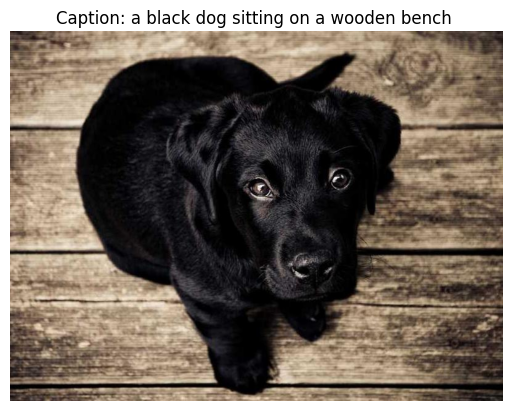

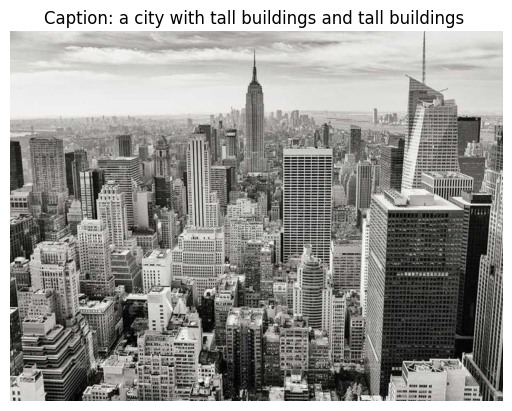

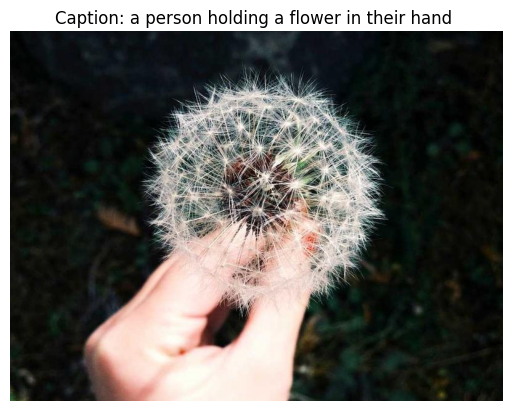

In [7]:
# display images and captions
for item in image_data:
    img = load_image_from_url(item["url"])
    caption = generate_caption(img)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Caption: {caption}")
    plt.show()

# Visual Question Answering with BLIP

In [8]:
blip_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to("cpu")
blip_proc = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [9]:
def answer_blip(image, question):
    inputs = blip_proc(image, question, return_tensors="pt").to(blip_model.device)
    output = blip_model.generate(**inputs)
    return blip_proc.decode(output[0], skip_special_tokens=True)

In [10]:
question = "What is the person doing?"

for item in image_data:
    img = load_image_from_url(item["url"])
    print(f"[{item}] Q: {question} → A: {answer_blip(img, question)}")

[{'url': 'https://picsum.photos/id/237/800/600', 'caption': 'A black dog looking up.'}] Q: What is the person doing? → A: standing
[{'url': 'https://picsum.photos/id/238/800/600', 'caption': 'New york city skyline in black-white.'}] Q: What is the person doing? → A: standing
[{'url': 'https://picsum.photos/id/239/800/600', 'caption': 'A person holding a dandelion.'}] Q: What is the person doing? → A: holding dandelion


# BLIP-2 Advanced QA

In [11]:
blip2_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b").to("cpu")
blip2_proc = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

In [12]:
def blip2_answer(image, prompt):
    inputs = blip2_proc(images=image, text=prompt, return_tensors="pt").to(blip2_model.device)
    out = blip2_model.generate(**inputs, max_new_tokens=50)
    return blip2_proc.tokenizer.decode(out[0], skip_special_tokens=True)

In [13]:
for item in image_data:
    img = load_image_from_url(item["url"])
    print("BLIP-2:", blip2_answer(img, "Describe this image."))

BLIP-2: Describe this image.

BLIP-2: Describe this image.

BLIP-2: Describe this image.



# Zero-shot Classification with CLIP

In [14]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cpu")
clip_proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [15]:
def classify_clip(image, labels):
    inputs = clip_proc(text=labels, images=image, return_tensors="pt", padding=True).to("cpu")
    probs = clip_model(**inputs).logits_per_image.softmax(dim=1).squeeze()
    return list(zip(labels, probs.tolist()))

# Run CLIP Classification

In [16]:
labels = ["a person", "a car", "a dog", "a group", "an animal"]
img = load_image_from_url(image_data[0]["url"])
print(classify_clip(img, labels))

[('a person', 0.009511380456387997), ('a car', 0.00039866872248239815), ('a dog', 0.8697912096977234), ('a group', 0.0006654983735643327), ('an animal', 0.11963330954313278)]


# CLIP Image-Text Similarity

In [17]:
def similarity_score(image, text):
    inputs = clip_proc(text=[text], images=image, return_tensors="pt", padding=True).to("cpu")
    return clip_model(**inputs).logits_per_image[0][0].item()

In [18]:
for item in image_data:
    img = load_image_from_url(item["url"])
    gt = item['caption']
    gen = generate_caption(img)
    print(f"[{item}] GT Sim: {similarity_score(img, gt):.2f}, Gen Sim: {similarity_score(img, gen):.2f}")

[{'url': 'https://picsum.photos/id/237/800/600', 'caption': 'A black dog looking up.'}] GT Sim: 30.40, Gen Sim: 30.14
[{'url': 'https://picsum.photos/id/238/800/600', 'caption': 'New york city skyline in black-white.'}] GT Sim: 30.44, Gen Sim: 26.77
[{'url': 'https://picsum.photos/id/239/800/600', 'caption': 'A person holding a dandelion.'}] GT Sim: 32.80, Gen Sim: 27.06


# OCR with pytesseract

In [19]:
import pytesseract

for item in image_data:
    img = load_image_from_url(item["url"])
    print(f"[{item}] Extracted Text:\n{pytesseract.image_to_string(img).strip()}")

[{'url': 'https://picsum.photos/id/237/800/600', 'caption': 'A black dog looking up.'}] Extracted Text:

[{'url': 'https://picsum.photos/id/238/800/600', 'caption': 'New york city skyline in black-white.'}] Extracted Text:

[{'url': 'https://picsum.photos/id/239/800/600', 'caption': 'A person holding a dandelion.'}] Extracted Text:



# Grounded Detection (OWL-ViT)

In [20]:
owl_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to("cpu")
owl_proc = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

In [21]:
def detect_objects(image, labels):
    inputs = owl_proc(images=image, text=labels, return_tensors="pt").to("cpu")
    outputs = owl_model(**inputs)

    probs = outputs.logits[0].sigmoid()

    scores, class_ids = probs[:, :len(labels)].max(dim=-1)

    score_threshold = 0.1
    keep = scores > score_threshold

    filtered_scores = scores[keep].detach().cpu().numpy()
    filtered_class_ids = class_ids[keep].detach().cpu().numpy()

    predicted_labels = [labels[i] for i in filtered_class_ids]

    return list(zip(predicted_labels, filtered_scores))

In [22]:
# object detection example
img = load_image_from_url(image_data[0]["url"])
print(detect_objects(img, ["dog", "ball", "person", "car"]))

[('dog', np.float32(0.116699934))]


# LangChain Agent with BLIP-2 Tool

In [23]:
def blip2_tool(input_str):
    url, question = input_str.split("|")
    image = load_image_from_url(url.strip())
    return blip2_answer(image, question.strip())\

tool = Tool(
    name="BLIP2-VQA",
    func=blip2_tool,
    description="Use this tool to answer visual questions. Input format: 'image_url|question'."
)

agent = initialize_agent(
    tools=[tool],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

<ipython-input-23-1cf2964979ff>:12: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [ ]:
# example: Ask about the second image in your list
img_url = image_data[1]['url']
question = "Explain the image in detail?"

input_string = f"{img_url}|{question}"
response = agent.run(f"Use BLIP2-VQA to answer this: {input_string}")
print("Gemini Agent Response:", response)